In [62]:
from __future__ import print_function
import sys
sys.path.append('../build/')
%pylab inline
np.set_printoptions(precision=4, suppress=True)
import versor as vsr
from versor.drawing import *
from motor_estimation import MotorEstimationSolver

Populating the interactive namespace from numpy and matplotlib


/Users/lars/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Inf', 'legend']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [63]:
p1 = vsr.Vec(1,0,1).null()
p2 = vsr.Vec(2,0.2,1).null()

l1 = vsr.Dll(vsr.Vec(0,0,0).null(), vsr.Vec(1,0,0).null()).unit()

theta = pi/6
delta = 0.6


m = vsr.Vec(1,1,delta).trs() * vsr.Biv(theta/2,0,0).exp()

l1 = l1.spin(m)
l2 = l1.spin(m)
l3 = l2.comm(l1.rev())

l1_dir = l1.dir().vec().unit()
l1_loc = l1.loc(vsr.Vec(0,0,0).null()).vec()
l2_dir = l2.dir().vec().unit()
l2_loc = l2.loc(vsr.Vec(0,0,0).null()).vec()

l4 = vsr.Dll(l3.loc(vsr.Vec(0,0,0).null()), l3.biv().duale().unit())

p1 = l1.loc(l4.loc(vsr.Vec(0,0,0).null()))
p2 = l2.loc(l4.loc(vsr.Vec(0,0,0).null()))

p = ((p2.vec() + p1.vec()) * 0.5).null()

# bisector

lv = vsr.Dll(p, (l2_dir + l1_dir).unit())
lw = vsr.Dll(p, (l2_dir-l1_dir).unit())


l5 = l2 - l1

scene = Scene(children=[
        frame_mesh(),
        line_mesh(l1, color=Colors.DEEPSKYBLUE),
        point_mesh(p1,color=Colors.DEEPSKYBLUE),

        line_mesh(l2, color=Colors.DEEPPINK),
        point_mesh(p2,color=Colors.DEEPPINK),
        
        line_mesh(l3, color=Colors.BLACK),
        
        line_mesh(l5, color='lightgreen'),
        
        # midpoint
        point_mesh(p, color='lightgreen'),

        
#         bivector_mesh(l3.biv(), color='red'),
#         vector_mesh(B1.comm(bn.comm(B2) * delta), color='red'),
        
        line_mesh(lv, color='lightgreen'),

        
        AmbientLight(color='#777777')])

camera = PerspectiveCamera(position=[0, 5, 5], up=[0, 0, 1],
                      children=[DirectionalLight(color='white', 
                                                 position=[3, 5, 1], 
                                                 intensity=0.5)])
# camera.children = []

renderer = Renderer(camera=camera, 
                    scene=scene, 
                    controls=[TrackballControls(controlling=camera)],
                    background = 'white')
renderer.width = '950'
renderer.height = '713'
# display(renderer)

# Ground truth motor

In [64]:
delta = 9
delta2 = -9
theta = pi/6
theta2 = -pi*1.4
motor = (vsr.Vec(0,0,1).unit() * delta ).trs() * vsr.Rot(vsr.Biv(1,0,0).unit() * theta)
motor2 = (vsr.Vec(-1,2,3).unit() * delta2 ).trs() * vsr.Rot(vsr.Biv(9,0,42).unit() * theta2)
motor3 = vsr.CGA(motor).spin(vsr.CGA(motor2)).mot()
print(motor)
print(motor2)
print(motor3)

Mot: [ 0.87 -0.5 0 0 0 0 -3.9 2.2 ]
Mot: [ -0.31 -0.2 0 -0.93 0.85 2.9 -3.4 0.4 ]
Mot: [ 0.87 0.36 0.29 -0.19 -5.3 -1.8 1.3 2.2 ]


# Dataset

In [65]:
n_points = 10
sigma = 0.09
points_a = [(vsr.Vec(0,0,0).null(),
             vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null()  )
            for i in range(n_points)]

points_a_noisy = [(vsr.Vec(*(np.array(a)[:3] + sigma * np.random.randn(3))).null(),
                   vsr.Vec(*(np.array(b)[:3] + sigma * np.random.randn(3))).null()) 
                  for a,b in points_a]

lines_a = [vsr.Dll(a,b).unit() for (a,b) in points_a]
lines_b = [line.spin(motor) for line in lines_a]

In [66]:
lines_a2 = [line.spin(motor2) for line in lines_a]
lines_b2 = [line.spin(motor2) for line in lines_b]

# Estimate motor

In [67]:
def mov(a,b):
#     C = a - b
    C = a.comm(b.rev())
    A = C.biv().unit()
    a = np.array(A.duale())
    f = C.drv().vec()
#     print(f)
    g = f.reject_from(A)
#     print(g)

    C[3] = g[0]
    C[4] = g[1]
    C[5] = g[2]
#     print(C)
    return np.inner(C,C)

In [68]:
np.sum([np.inner(a-b, a-b) for a,b in zip(lines_a2, lines_b2)]) * 0.5

600.99518730709724

In [69]:
np.sum([mov(a,b) for a,b in zip(lines_a2[:], lines_b2[:])]) * 0.5

98.904984425164486

In [70]:
def ln(a,b):
    C = a.comm(b.rev())

    A = C.biv().unit()
    a = np.array(A.duale())
#     print(a)
    f = C.drv().vec()
    
    #     print(f)
#     print(np.inner(a,f)*a)
    g = f.reject_from(A)
    h = f.project_onto(A)
    p = C.loc(vsr.Vec(0,0,0).null()).vec()
    return (C,  
            vsr.Dll(C[0],C[1],C[2],g[0],g[1],g[2]),
            C.spin((p.trs() * vsr.Rot(1,0,0,0)).rev()))
C = ln(vsr.Dll(0,0,1,0,0,0).spin(motor2), 
       vsr.Dll(0,0,1,0,0,0).spin(motor).spin(motor2))
print(C[0])
print(C[1])
print(C[2])
print(C[1].drv().vec().norm())

Dll: [ -0.6318 -0.4977 0.321 8.299 1.79 -0.5418 ]
Dll: [ -0.6318 -0.4977 0.321 1.668 2.586 -3.283 ]
Dll: [ -0.6318 -0.4977 0.321 1.668 2.586 -3.283 ]
4.5000000000000036


In [71]:
lines_a = [vsr.Dll(1,0,0,0,0,0).spin(motor3),
           vsr.Dll(0,1,0,0,0,0).spin(motor3),
           vsr.Dll(0,0,1,0,0,0).spin(motor3)]
lines_b = [vsr.Dll(1,0,0,0,0,0).spin((vsr.Vec(1,0,0).unit() * 7 ).trs() * 
                                      vsr.Rot(vsr.Biv(0,0,-1).unit() * (pi/6))).spin(motor3),
           vsr.Dll(0,1,0,0,0,0).spin((vsr.Vec(0,0,1).unit() * 7 ).trs() * 
                                     vsr.Rot(vsr.Biv(1,0,0).unit() * (pi/6))).spin(motor3),
           vsr.Dll(0,0,1,0,0,0).spin((vsr.Vec(0,1,1).unit() * 7 ).trs() * 
                                     vsr.Rot(vsr.Biv(1,1,0).unit() * (pi/6))).spin(motor3)]

In [72]:
lines_a

[Dll: [ 0.7662 0.5306 0.3625 -2.524 -10.32 -5.955 ],
 Dll: [ -0.1113 0.6652 -0.7384 -4.232 5.748 -6.276 ],
 Dll: [ -0.6329 0.5253 0.5687 -3.886 3.148 -6.104 ]]

In [73]:
lines_b

[Dll: [ 0.4795 -0.3107 0.8207 2.016 -15.68 6.713 ],
 Dll: [ -0.6038 0.7875 0.1233 0.9853 7.794 -9.965 ],
 Dll: [ 0.2209 0.1803 0.9585 0.03311 -5.307 -4.476 ]]

In [74]:
print(ln(lines_a[0], lines_b[0])[2].drv().vec().norm())
print(ln(lines_a[1], lines_b[1])[2].drv().vec().norm())
print(ln(lines_a[2], lines_b[2])[2].drv().vec().norm())

3.500000000000003
3.500000000000006
2.808666774861361e-15


In [75]:
7 * cos(pi/3)

3.5000000000000009

In [76]:
vsr.Dll(2,0,0,1,0,0).unit()

Dll: [ 1 0 0 0.5 0 0 ]


Solver Summary (v 1.12.0-eigen-(3.3.1)-lapack-suitesparse-(4.5.3)-cxsparse-(3.1.9)-no_openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Effective parameters                        6                        6
Residual blocks                             5                        5
Residual                                   30                       30

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                                     1                        1
Linear solver threads                       1                        1
Linear solver ordering              AUTOMATIC        

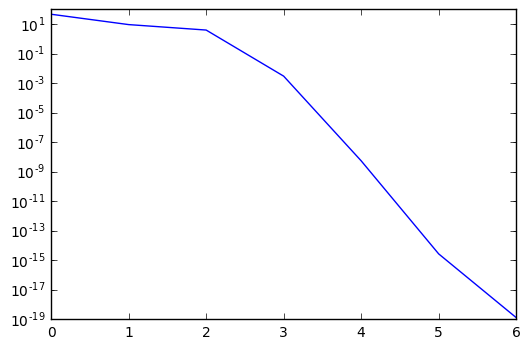

In [86]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(lines_a2[:5], lines_b2[:5]):
#     mes.add_line_correspondences_residual_block(a,b)
#     mes.add_line_commutator_residual_block(a,b)
#     mes.add_line_dual_angle_residual_block(a,b)
    mes.add_line_projected_commutator_residual_block(a,b)
#     mes.add_line_inner_product_residual_block(a,b)
#     mes.add_line_anticommutator_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
# mes.set_parameterization('POLAR_DECOMPOSITION_TANGENT')
mes.linear_solver_type = 'DENSE_QR'

# mes.max_num_iterations = 100

# mes.gradient_tolerance = 1e-16
(em_lines_6_res, summary_lines_6_res, _) = mes.solve()
print(summary_lines_6_res['full_report'])

semilogy([it['cost'] for it in summary_lines_6_res['iterations']])
print(np.allclose(motor3, em_lines_6_res, rtol=1e-4))
print('ground truth: ', np.array(motor3))
print('estimated:    ', np.array(em_lines_6_res))
print('M_err = M_t * ~M_est:\n\t      ',motor3 * em_lines_6_res.rev())
print('1 - || M_err ||: ', 1.0 - np.linalg.norm(np.array(motor3 * em_lines_6_res.rev())))

In [88]:
def daniilidis_motor(LAs, LBs):
    Ds = []
    for LA, LB in zip(LAs, LBs):
        D = np.zeros((8,8))
        for i in range(8):
            ei = vsr.Mot(0,0,0,0,0,0,0,0)
            ei[i] = 1.0
            D[:,i] = np.array(ei * LA - LB * ei)
        Ds.append(D[1:7,:].copy())
    
    Ds = np.array(Ds).reshape(-1,8)
    [U, s, Vt] = np.linalg.svd(Ds)
    print(Ds)

    v7 = Vt.T[:,-2].copy()
    v8 = Vt.T[:,-1].copy()
    
    v7 = np.array([v7[0], v7[3], -v7[2], v7[1], -v7[7],v7[4], v7[5], v7[6]])
    v8 = np.array([v8[0], v8[3], -v8[2], v8[1], -v8[7],v8[4], v8[5], v8[6]])
    
    u1 = v7[:4]
    v1 = v7[4:]
    u2 = v8[:4]
    v2 = v8[4:]

    a = np.inner(u1,v1)
    b = np.inner(u1,v2) + np.inner(u2,v1)
    c = np.inner(u2,v2)
    [s1, s2] = np.roots([a,b,c])

    val1 = (s1**2 * np.inner(u1,u1)) + (2 * s1 * np.inner(u1,u2)) + (np.inner(u2,u2))
    val2 = (s2**2 * np.inner(u1,u1)) + (2 * s2 * np.inner(u1,u2)) + (np.inner(u2,u2))
    
    if val1 > val2:
        s = s1
        val = val1
    else:
        s = s2
        val = val2

    lambda2 = np.sqrt(1./val)
    lambda1 = s * lambda2
    
    m_arr = lambda1 * Vt.T[:,-2] + lambda2 * Vt.T[:,-1]

    return vsr.Mot(*m_arr), lambda1, lambda2, v7, v8

In [89]:
print(np.array(motor3))

[ 0.866   0.3648  0.2874 -0.1853 -5.273  -1.7801  1.2606  2.25  ]


In [90]:
mdan, _, _, _, _ = daniilidis_motor(lines_a2[:5], lines_b2[:5])
print(mdan * -1)

[[ -0.4107   0.       0.1691  -1.6573   0.       0.       0.       0.    ]
 [ -0.0434  -0.1691   0.      -0.5357   0.       0.       0.       0.    ]
 [ -0.8759   1.6573   0.5357   0.       0.       0.       0.       0.    ]
 [ -5.4574  -3.9674   4.0368   0.       0.      -0.5357   1.6573   0.8759]
 [ 11.2073 -17.1289   0.       4.0368   0.5357   0.       0.1691  -0.0434]
 [ -4.9729   0.     -17.1289   3.9674  -1.6573  -0.1691   0.       0.4107]
 [ -0.6509   0.       1.2625  -1.0839   0.       0.       0.       0.    ]
 [  0.6509  -1.2625   0.       0.5568   0.       0.       0.       0.    ]
 [ -0.2718   1.0839  -0.5568   0.       0.       0.       0.       0.    ]
 [ -7.5052  13.5451   1.9895   0.       0.       0.5568   1.0839   0.2718]
 [  0.4312 -16.4395   0.       1.9895  -0.5568   0.       1.2625   0.6509]
 [ -8.3289   0.     -16.4395 -13.5451  -1.0839  -1.2625   0.       0.6509]
 [ -0.1887   0.       0.1433  -0.6596   0.       0.       0.       0.    ]
 [ -0.2938  -0.1433   0. 

In [20]:
motor3

Mot: [ 0.87 0.36 0.29 -0.19 -5.3 -1.8 1.3 2.2 ]

In [21]:
print(motor3 * em_lines_6_res.rev())
print(1.0 - np.linalg.norm(np.array(motor3 * em_lines_6_res.rev())))

Mot: [ 1 9.5e-13 8.2e-13 2.7e-13 -1.2e-11 -9.8e-12 -4.9e-12 -8.9e-16 ]
-4.4408920985e-16


In [22]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(lines_a2, lines_b2):
#     mes.add_line_correspondences_residual_block(a,b)
    mes.add_line_commutator_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
# mes.set_parameterization('POLAR_DECOMPOSITION_TANGENT')
mes.linear_solver_type = 'DENSE_QR'
(em_lines_6_res2, summary_lines_6_res2, _) = mes.solve()
print(summary_lines_6_res2['full_report'])
# print(motor)
print(em_lines_6_res2)
print(motor3)


Solver Summary (v 1.12.0-eigen-(3.3.1)-lapack-suitesparse-(4.5.3)-cxsparse-(3.1.9)-no_openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Effective parameters                        6                        6
Residual blocks                            10                       10
Residual                                   60                       60

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                                     1                        1
Linear solver threads                       1                        1
Linear solver ordering              AUTOMATIC        

In [23]:
print(motor3 * em_lines_6_res2.rev())

Mot: [ 1 5e-14 -1.3e-14 -1.5e-14 -2e-13 1.4e-13 -1e-13 -8.9e-16 ]


In [24]:
1. - np.linalg.norm(motor3 * em_lines_6_res2.rev())

-2.2204460492503131e-16

## Difference

In [25]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(lines_a, lines_b):
    mes.add_line_correspondences_residual_block(a,b)
mes.gradient_tolerance = 1e-12
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(em_lines_6_res, summary_lines_6_res, _) = mes.solve()
# print(summary_lines_6_res['full_report'])
print(em_lines_6_res)

Mot: [ 0.9 -0.41 -0.15 -0.0089 -9.6 -11 35 -18 ]


# Gauss-Newton

## Commutator

In [26]:
Jci = lambda ei, M, l1, l2 : np.array((ei.comm(l1.spin(M))).comm(l2)) * 2

In [27]:
fci = lambda M, l1, l2 : np.array(l1.spin(M).comm(l2)).reshape(6,1)

In [28]:
M = initial_motor
eps1 = 1e-6
eps2 = 1e-6
rsc = []
for i in range(50):
    k = len(rsc)
    Jc = np.array([np.array([Jci(ei, M, a, b) for ei in [vsr.Dll(1,0,0,0,0,0), 
                                                         vsr.Dll(0,1,0,0,0,0),
                                                         vsr.Dll(0,0,1,0,0,0),
                                                         vsr.Dll(0,0,0,1,0,0),
                                                         vsr.Dll(0,0,0,0,1,0),
                                                         vsr.Dll(0,0,0,0,0,1)]]).reshape(6,6).T 
                for a, b in zip(lines_a2, lines_b2)]).reshape(-1,6)
#     print(Jc)
    fc = np.array([fci(M,a,b) for a, b in zip(lines_a2, lines_b2)]).reshape(-1,1)
    A = np.dot(Jc.T,Jc)
    g = np.dot(Jc.T, fc)
    r = np.dot(fc.T,fc)[0][0] / 2
    rsc.append(r)
    if r < 1e-6:
        break
    h = np.dot(np.linalg.pinv(A), -g)
#     h = -g
    B = vsr.Dll(*h)
    M = B.exp() * M
print('r: ', r)
print(k)    
print(M)
print(motor3)

r:  3.39746569785e-12
4
Mot: [ 0.87 0.36 0.29 -0.19 -5.3 -1.8 1.3 2.3 ]
Mot: [ 0.87 0.36 0.29 -0.19 -5.3 -1.8 1.3 2.2 ]


In [29]:
lines_a = [vsr.Dll(0,0,1,0,0,0), vsr.Dll(0,-1,0,0,0,0)]
lines_b = [a.spin(motor) for a in lines_a]

Jci = lambda ei, M, l1, l2 : np.array(((ei.comm(l1.spin(M))).comm(l2)).mot().dll()) * 2
fci = lambda M, l1, l2 : np.array((l1.spin(M).comm(l2)).mot().dll()).reshape(6,1)
M = initial_motor
eps1 = 1e-6
eps2 = 1e-6
rsc = []
for i in range(10):
    k = len(rsc)
    Jc = np.array([np.array([Jci(vsr.CGA(ei), 
                                 vsr.CGA(M), 
                                 vsr.CGA(a.undual()),
                                 vsr.CGA(b.undual())) for ei in [vsr.Dll(1,0,0,0,0,0), 
                                                      vsr.Dll(0,1,0,0,0,0),
                                                      vsr.Dll(0,0,1,0,0,0),
                                                      vsr.Dll(0,0,0,1,0,0),
                                                      vsr.Dll(0,0,0,0,1,0),
                                                      vsr.Dll(0,0,0,0,0,1)]]).reshape(6,6).T 
                for a, b in zip(lines_a2, lines_b2)]).reshape(-1,6)
#     print(Jc)
    fc = np.array([fci(vsr.CGA(M),
                       vsr.CGA(a.undual()),
                       vsr.CGA(b.undual())) for a, b in zip(lines_a, lines_b)]).reshape(-1,1)
    
    
    A = np.dot(Jc.T,Jc)
    g = np.dot(Jc.T,fc)
    r = np.dot(fc.T,fc)[0][0] / 2
    rsc.append(r)
    if r < 1e-6:
        break
    h = np.dot(np.linalg.pinv(A), -g)
    B = vsr.Dll(*h)
#     M = B.exp() * M
    M = (M + B*M)
    M = M.retract()
print('r: ', r)
print(k)    
print(M)

ValueError: shapes (6,60) and (12,1) not aligned: 60 (dim 1) != 12 (dim 0)

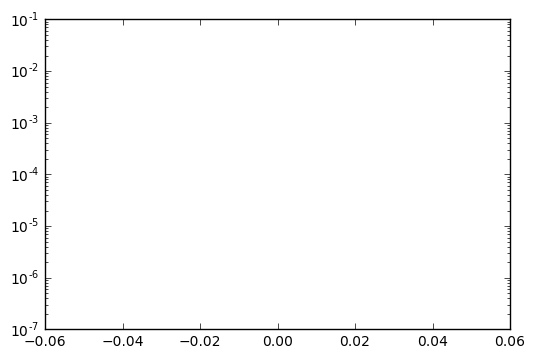

In [30]:
semilogy(rsc)

## Difference

In [31]:
Jdi = lambda ei, M, l1, l2 : np.array((ei.comm(l1.spin(M)))) * 2

In [32]:
fdi = lambda M, l1, l2 : np.array(l1.spin(M) - l2).reshape(6,1)

In [33]:
M = initial_motor
rsd = []
for i in range(10):
    k = len(rsd)
    Jd = np.array([np.array([Jdi(ei, M, a, b) for ei in [vsr.Dll(1,0,0,0,0,0), 
                                                      vsr.Dll(0,1,0,0,0,0),
                                                      vsr.Dll(0,0,1,0,0,0),
                                                      vsr.Dll(0,0,0,1,0,0),
                                                      vsr.Dll(0,0,0,0,1,0),
                                                      vsr.Dll(0,0,0,0,0,1)]]).reshape(6,6).T 
                for a, b in zip(lines_a, lines_b)]).reshape(-1,6)
    fd = np.array([fdi(M,a,b) for a, b in zip(lines_a, lines_b)]).reshape(-1,1)
    A = np.dot(Jd.T,Jd)
    g = np.dot(Jd.T, fd)
    r = np.dot(fd.T,fd)[0][0] / 2
    rsd.append(r)
    if r < 1e-6:
        print('r: ', r)
        break
    h = np.dot(np.linalg.pinv(A), -g)
    B = vsr.Dll(*h)
    M = B.exp() * M
print(k)
print(M)

r:  6.73414137495e-08
4
Mot: [ 0.87 -0.5 0 0 0 0 -3.9 2.3 ]


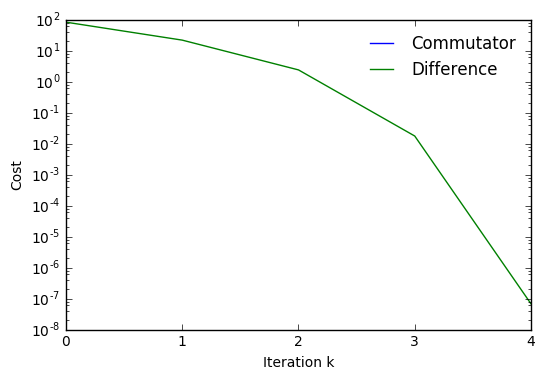

In [34]:
fig, ax = plt.subplots(1)
ax.plot(rsc, label=r'Commutator')
ax.plot(rsd, label=r'Difference')
ax.semilogy()
legend = ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel(r'Iteration k')
plt.ylabel(r'Cost')
# plt.savefig('lines-cost-engage.eps')

## Planes

In [35]:
n_planes = 10
planes_a = []
for i in range(10):
    dir_vec = np.random.normal(0.0, 0.8, 4)
    dir_vec = dir_vec / np.linalg.norm(dir_vec)
    distance = np.random.normal(0.0, 0.8,1)
    arr = dir_vec + distance
    planes_a.append(vsr.Dlp(dir_vec[0],dir_vec[1],dir_vec[2],distance[0]))
planes_b = [plane.spin(motor3) for plane in planes_a]

In [36]:
def lnpl(a,b):
    print(a)
    print(b)
    C = a.comm(b.rev())
    print(C)
    A = C.biv().unit()
    a = np.array(A.duale())
#     print(a)
    f = C.drv().vec()
    
    #     print(f)
#     print(np.inner(a,f)*a)
    g = f.reject_from(A)
    print(g)
    p = C.loc(vsr.Vec(0,0,0).null()).vec()

    return (C,  
            vsr.Dll(C[0],C[1],C[2],g[0],g[1],g[2]),
            C.spin((p.trs() * vsr.Rot(1,0,0,0)).rev()))
C = lnpl(vsr.Dlp(0,0,1,0).spin(motor3), 
       vsr.Dlp(0,0,1,0).spin(motor).spin(motor3))
print(C[0])
print(C[1])
print(C[2])
print(C[1].drv().vec().norm())

Dlp: [ 0.3625 -0.5306 0.7662 -1.454 ]
Dlp: [ 0.3625 -0.5306 0.7662 7.546 ]
Dll: [ 0 0 0 3.263 -4.776 6.895 ]
Vec: [ 0 0 0 ]
Dll: [ 0 0 0 3.263 -4.776 6.895 ]
Dll: [ 0 0 0 0 0 0 ]
Dll: [ 0 0 0 3.263 -4.776 6.895 ]
0.0


In [37]:
motor

Mot: [ 0.87 -0.5 0 0 0 0 -3.9 2.2 ]

In [38]:
ln

<function __main__.ln>

Ceres Solver Report: Iterations: 11, Initial cost: 1.161530e+02, Final cost: 2.938320e-20, Termination: CONVERGENCE
True
ground truth:  [ 0.866   0.3648  0.2874 -0.1853 -5.273  -1.7801  1.2606  2.25  ]
estimated:     [ 0.866   0.3648  0.2874 -0.1853 -5.273  -1.7801  1.2606  2.25  ]
M_err = M_t * ~M_est:
	       Mot: [ 1 1.1e-12 -4.4e-13 -1.6e-12 6.3e-11 -5.8e-11 -2e-11 -8.9e-16 ]
1 - || M_err ||:  -2.22044604925e-16


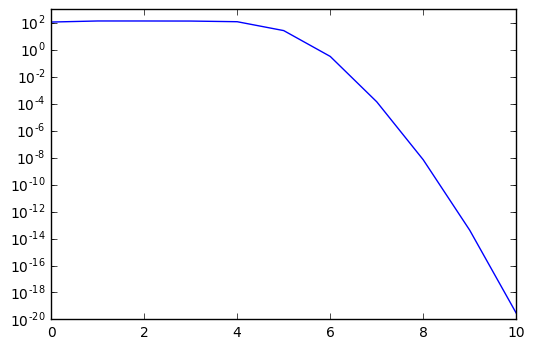

In [46]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(planes_a, planes_b):
    mes.add_dual_plane_commutator_residual_block(a,b)
#     mes.add_dual_plane_difference_residual_block(a,b)
# mes.gradient_tolerance = 1e-12
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(em_lines_6_res, summary_lines_6_res, _) = mes.solve()

print(summary_lines_6_res['brief_report'])

semilogy([it['cost'] for it in summary_lines_6_res['iterations']])
print(np.allclose(motor3, em_lines_6_res, rtol=1e-4))
print('ground truth: ', np.array(motor3))
print('estimated:    ', np.array(em_lines_6_res))
print('M_err = M_t * ~M_est:\n\t      ',motor3 * em_lines_6_res.rev())
print('1 - || M_err ||: ', 1.0 - np.linalg.norm(np.array(motor3 * em_lines_6_res.rev())))

In [48]:
print(motor3 * em_lines_6_res.rev())

Mot: [ 1 -6.6e-12 -4.3e-12 1.6e-12 4.4e-09 -2.3e-09 3e-09 -2.2e-15 ]


In [49]:
motor3

Mot: [ 0.87 0.15 0.39 -0.27 -5.9 -0.0062 0.65 2 ]

In [ ]:
Jci = lambda ei, M, l1, l2 : np.array(((ei.comm(l1.spin(M))).comm(l2)).mot().dll()) * 2
fci = lambda M, l1, l2 : np.array((l1.spin(M).comm(l2)).mot().dll()).reshape(6,1)

In [42]:
M = initial_motor
eps1 = 1e-6
eps2 = 1e-6
rsc = []
for i in range(10):
    k = len(rsc)
    Jc = np.array([np.array([Jci(vsr.CGA(ei), 
                                 vsr.CGA(M), 
                                 vsr.CGA(a),
                                 vsr.CGA(b)) for ei in [vsr.Dll(1,0,0,0,0,0), 
                                                      vsr.Dll(0,1,0,0,0,0),
                                                      vsr.Dll(0,0,1,0,0,0),
                                                      vsr.Dll(0,0,0,1,0,0),
                                                      vsr.Dll(0,0,0,0,1,0),
                                                      vsr.Dll(0,0,0,0,0,1)]]).reshape(6,6).T 
                for a, b in zip(planes_a, planes_b)]).reshape(-1,6)
    fc = np.array([fci(vsr.CGA(M),
                       vsr.CGA(a),
                       vsr.CGA(b)) for a, b in zip(planes_a, planes_b)]).reshape(-1,1)

    A = np.dot(Jc.T,Jc)
    g = np.dot(Jc.T,fc)
    r = np.dot(fc.T,fc)[0][0] / 2
    rsc.append(r)
    if r < 1e-6:
        break
    h = np.dot(np.linalg.pinv(A), -g)
    B = vsr.Dll(*h)
    M = B.exp() * M
print('r: ', r)
print(k)    
print(M)

r:  2.29085842739e-12
4
Mot: [ 0.87 0.36 0.29 -0.19 -5.3 -1.8 1.3 2.2 ]


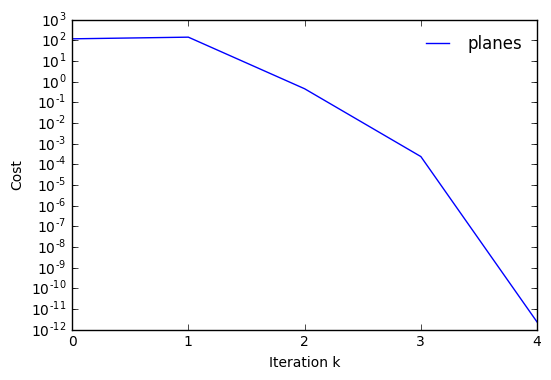

In [43]:
fig, ax = plt.subplots(1)
ax.plot(rsc, label=r'planes')
ax.semilogy()
legend = ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel(r'Iteration k')
plt.ylabel(r'Cost')
# plt.savefig('lines-cost-engage.eps')

## Points

In [ ]:
one = vsr.CGA(*[0]*32); one[0] = 1; print('one :', one)
ni = vsr.CGA(*[0]*32); ni[5] = 1; print('ni :', ni)
no = vsr.CGA(*[0]*32); no[4] = 1; print('no: ', no)
E = no ^ ni; print('E :', E)
a = vsr.CGA(vsr.Vec(1,2,3)); print('a: ', a)
b = vsr.CGA(vsr.Vec(-2,3,-4)); print('b: ',b)
p = (a^ni) + E; print('p: ', p)
q = (b^ni) + E; print('q: ', q)

In [ ]:
q.acomm(p)

In [ ]:
q.comm(p)

In [ ]:
q <= p.inv()

In [ ]:
dlp = vsr.CGA(vsr.Dlp(vsr.Vec(1,2,3).unit(), 5)); print(dlp)

In [ ]:
e1 = vsr.CGA(vsr.Vec(1,0,0))
e2 = vsr.CGA(vsr.Vec(0,1,0))
e3 = vsr.CGA(vsr.Vec(0,0,1))
I3 = e1 * e2 * e3
I = no * I3 * ni

In [ ]:
e1r = (-1)**0 * (e2 ^ e3 ^ no ^ ni) <= I.inv()
e2r = (-1)**1 * (e1 ^ e3 ^ no ^ ni) <= I.inv()
e3r = (-1)**2 * (e1 ^ e2 ^ no ^ ni) <= I.inv()
nor = (-1)**3 * (e1 ^ e2 ^ e3 ^ ni) <= I.inv()
nir = (-1)**4 * (e1 ^ e2 ^ e3 ^ no) <= I.inv()

In [ ]:
print((e1 * e1r)[0])
print((e2 * e2r)[0])
print((e3 * e3r)[0])
print((no * nor)[0])
print((ni * nir)[0])

In [ ]:
e1nir= (-1)**1 * (e2 ^ e3 ^ no) <= I.inv()
e2nir= (-1)**2 * (e1 ^ e3 ^ no) <= I.inv()
e3nir= (-1)**3 * (e1 ^ e2 ^ no) <= I.inv()

In [ ]:
A = e1 ^ e2
B = e1 ^ e2

In [ ]:
A * (epsr * A.rev())

In [ ]:
(eps * B) * (epsr * B.rev())

In [ ]:
l = vsr.Dll(vsr.Vec(1,2,3).null(), vsr.Vec(3,2,1).unit()); l
ls = vsr.

In [ ]:
A = l.biv(); A

In [ ]:
B = l.drv().vec().unduale(); B

In [ ]:
lc = vsr.CGA(A) + eps * vsr.CGA(B); lc

In [ ]:
lcr = vsr.CGA(A.rev()) + vsr.CGA(B.rev()) * epsr; lcr

In [ ]:
l * l.rev()

In [ ]:
l * l.rev()

In [ ]:
(gr0)

In [ ]:
(lc * lcr)[0]

In [ ]:
np.inner(lc,lc)

In [ ]:
B.duale()

In [ ]:
epsr = I3 * no

In [ ]:
epsr<=eps

In [ ]:
e1ni = vsr.CGA(vsr.Dll(0,0,0,1,0,0))
e2ni = vsr.CGA(vsr.Dll(0,0,0,0,1,0))
e3ni = vsr.CGA(vsr.Dll(0,0,0,0,0,1))

In [ ]:
print(e1ni<=e1nir)
print(e2ni<=e2nir)
print(e3ni<=e3nir)

In [ ]:
(-1)**5

In [ ]:
(-1)**(4)

In [ ]:
ni
nir

In [ ]:
ni <= nir

In [ ]:
s = vsr.CGA(*[0]*32); s[0]=1; s 

In [ ]:
s.dual()

In [ ]:
pln = dlp.undual(); pln

In [ ]:
pln * I.inv()

In [ ]:
print(dlp.undual() <= I.inv())

In [ ]:
print(dlp <= I)

In [ ]:
q - p

In [ ]:
q.comm(p).rev()

 (b - a)^ ni

In [ ]:
q.inv()

In [ ]:
E.inv()

In [ ]:
no.conj()

In [ ]:
q.inv()

In [ ]:
q * q.rev()

In [ ]:
q * p.inv()

In [ ]:
q * (q * q.conj())

In [ ]:
q

In [ ]:
T * q

In [ ]:
q - p

In [ ]:
((a^ni) - (b^ni)) * -1

In [ ]:
((b^ni) - (a^ni)) 

In [ ]:
(b.comm(ni)).comm(E)

In [ ]:
E * (a ^ ni)

In [ ]:
(a ^ ni).comm(b ^ ni)

In [ ]:
(b ^ ni) * E

In [ ]:
E * E

## Planes

In [ ]:
a = vsr.CGA(vsr.Vec(0,0,1).unit())
print(a.norm())
alpha = 1.0
P = a; print(P)
theta = pi/7
b = a.spin(vsr.CGA(vsr.Biv(0,0,-theta/2).exp()))
print(b.norm())
beta = 2.0
Q = b; print(Q)

In [ ]:
T = vsr.CGA(vsr.Vec(1,2,3).trs() * vsr.Rot(1,0,0,0))
T

In [ ]:
eps = vsr.CGA(vsr.Mot(0,0,0,0,0,0,0,-1))

In [ ]:
T = vsr.CGA(vsr.Vec(1,2,3))
print(T)
trs = one - eps * T * 0.5
trs = vsr.CGA(vsr.Vec(1,2,3).trs() * vsr.Rot(1,0,0,0)); print(trs)

In [ ]:
Pp = a.spin(trs)

In [ ]:
Qp = b.spin(trs)

In [ ]:
Qp * Pp

In [ ]:
B = (a ^ b).unit()
B

In [ ]:
B.spin(trs)

In [ ]:
t = vsr.CGA(vsr.Vec(1,2,3))
(a<=t)*b - (b<=t)*a

In [ ]:
(t <= (b ^ a ))

In [ ]:
t <= (a^b) * -1

In [ ]:
(t ^ (a^b).dual()) * eps

In [ ]:
(Qp - Pp)

In [ ]:
(Qp - Pp).unit()

In [ ]:
(b -a).norm()

In [ ]:
(b-a)<=t

In [ ]:
vsr.CGA(vsr.EGA(0,0,0,0,0,0,0,1))

In [ ]:
vsr.Biv(0,0,-theta/2).exp()

In [ ]:
a ^ b

In [ ]:
sin(theta)

In [ ]:
((a ^ b) * sin(2 * theta)).spin(trs)

In [ ]:
B = (a ^ b).unit()

In [ ]:
B.spin(trs) * 2 * sin(theta)

In [ ]:
Qp * Pp

In [ ]:
arccos((a <= b)[0])

In [ ]:
pi/3

In [ ]:
b * a

In [ ]:
Q.inv()

In [ ]:
e1 = vsr.CGA(vsr.Vec(1,0,0))
e2 = vsr.CGA(vsr.Vec(0,0,0))
e3 = vsr.CGA(vsr.Vec(0,0,1))
I3 = e1 * e2 * e3
I = no * I3 * ni

In [ ]:
Q

In [ ]:
print(P.comm(Q))

In [ ]:
a.comm(b)

In [ ]:
S = P.comm(Q); print(S)

In [ ]:
s = S.mot().dll()

In [ ]:
l = s.biv().duale()

In [ ]:
lb = s.drv().vec()

In [ ]:
np.inner(l,lb)

In [ ]:
np.inner(l,l) + np.inner(lb,lb)

In [ ]:
np.inner(s,s)

In [ ]:
beta * a - alpha * b

In [ ]:
np.inner(l,l) + (beta**2) + (alpha**2) - alpha * beta * np.inner(a,b) * 2.0

In [ ]:
th2 = np.arctan2(l.norm(), (a <= b).norm())

In [ ]:
pi/3

In [ ]:
np.inner(a,b)

In [ ]:
cos(pi/3)

In [ ]:
np.inner(a,a)

In [ ]:
np.inner(b,b)

In [ ]:
cos(theta)

In [ ]:
print(a)
print(b)

In [ ]:
a <= b

In [ ]:
sin(theta)

In [ ]:
np.inner(S,S)

In [ ]:
sin(theta)**2 

In [ ]:
print(np.inner(s,s))
print(sin(th2)**2 + alpha**2 + beta**2 - 2 * alpha * beta * cos(th2))

In [ ]:
R = P - Q 

In [ ]:
np.inner(R,R)

In [ ]:
2 * (1 - cos(th2) - alpha * beta) + beta**2 + alpha**2

In [ ]:
1 - cos(th2)

In [ ]:
(alpha - beta)**2 + 4 * sin(th2/2)**2

In [ ]:
n_points=10
points_a = [vsr.CGA(vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null()) ^ ni for i in range(n_points)]
points_b = [point.spin(vsr.CGA(motor)) for point in points_a]

In [ ]:
n_points=10
points_a = [vsr.CGA(vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null()) for i in range(n_points)]
points_ani = [a ^ ni for a in points_a]
points_b = [point.spin(vsr.CGA(motor)) for point in points_a]
points_bni = [b ^ ni for b in points_b]

In [ ]:
print(points_a[0])
print(points_ani[0])
print(points_b[0]);
print(points_bni[0]);

In [ ]:
points_ani[0] * points_bni[0]

In [ ]:
points_ani[0] * points_bni[0]

In [ ]:
points_bni[0] - points_ani[0]

In [ ]:
M = initial_motor
eps1 = 1e-6
eps2 = 1e-6
rsc = []
for i in range(10):
    k = len(rsc)
    Jc = np.array([np.array([Jci(vsr.CGA(ei), 
                                 vsr.CGA(M), 
                                 (a),
                                 (b)) for ei in [vsr.Dll(1,0,0,0,0,0), 
                                                      vsr.Dll(0,1,0,0,0,0),
                                                      vsr.Dll(0,0,1,0,0,0),
                                                      vsr.Dll(0,0,0,1,0,0),
                                                      vsr.Dll(0,0,0,0,1,0),
                                                      vsr.Dll(0,0,0,0,0,1)]]).reshape(6,6).T 
                for a, b in zip(points_a, points_b)]).reshape(-1,6)
    fc = np.array([fci(vsr.CGA(M),
                       (a),
                       (b)) for a, b in zip(points_a, points_b)]).reshape(-1,1)

#     print(Jc)
    A = np.dot(Jc.T,Jc)
#     print(A)
    g = np.dot(Jc.T,fc)
    r = np.dot(fc.T,fc)[0][0] / 2
    rsc.append(r)
    if r < 1e-6:
        break
#     h = np.dot(np.linalg.pinv(A), -g)
    h = np.linalg.solve(A,-g)
    B = vsr.Dll(*h)
    M = B.exp() * M
print('r: ', r)
print(k)    
print(M)

In [ ]:
print(Jc[:6,:])

In [ ]:
fig, ax = plt.subplots(1)
ax.plot(rsc, label=r'points')
ax.semilogy()
legend = ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel(r'Iteration k')
plt.ylabel(r'Cost')
# plt.savefig('lines-cost-engage.eps')

# Points, Lines, and Planes

In [ ]:
Jci = lambda ei, M, l1, l2 : np.array(((ei.comm(l1.spin(M))).comm(l2)).mot().dll()) * 2
fci = lambda M, l1, l2 : np.array((l1.spin(M).comm(l2)).mot().dll()).reshape(6,1)
M = initial_motor
eps1 = 1e-6
eps2 = 1e-6
rsc = []
for i in range(10):
    k = len(rsc)
    Jlin = np.array([np.array([Jci(vsr.CGA(ei), 
                                 vsr.CGA(M), 
                                 vsr.CGA(a.undual()),
                                 vsr.CGA(b.undual())) for ei in [vsr.Dll(1,0,0,0,0,0), 
                                                      vsr.Dll(0,1,0,0,0,0),
                                                      vsr.Dll(0,0,1,0,0,0),
                                                      vsr.Dll(0,0,0,1,0,0),
                                                      vsr.Dll(0,0,0,0,1,0),
                                                      vsr.Dll(0,0,0,0,0,1)]]).reshape(6,6).T 
                for a, b in zip(lines_a, lines_b)]).reshape(-1,6)
    flin = np.array([fci(vsr.CGA(M),
                       vsr.CGA(a.undual()),
                       vsr.CGA(b.undual())) for a, b in zip(lines_a, lines_b)]).reshape(-1,1)
    Jpln = np.array([np.array([Jci(vsr.CGA(ei), 
                                 vsr.CGA(M), 
                                 vsr.CGA(a.undual()),
                                 vsr.CGA(b.undual())) for ei in [vsr.Dll(1,0,0,0,0,0), 
                                                      vsr.Dll(0,1,0,0,0,0),
                                                      vsr.Dll(0,0,1,0,0,0),
                                                      vsr.Dll(0,0,0,1,0,0),
                                                      vsr.Dll(0,0,0,0,1,0),
                                                      vsr.Dll(0,0,0,0,0,1)]]).reshape(6,6).T 
                for a, b in zip(planes_a, planes_b)]).reshape(-1,6)
    fpln = np.array([fci(vsr.CGA(M),
                       vsr.CGA(a.undual()),
                       vsr.CGA(b.undual())) for a, b in zip(planes_a, planes_b)]).reshape(-1,1)
    
    Jpnt = np.array([np.array([Jci(vsr.CGA(ei), 
                                 vsr.CGA(M), 
                                 (a),
                                 (b)) for ei in [vsr.Dll(1,0,0,0,0,0), 
                                                      vsr.Dll(0,1,0,0,0,0),
                                                      vsr.Dll(0,0,1,0,0,0),
                                                      vsr.Dll(0,0,0,1,0,0),
                                                      vsr.Dll(0,0,0,0,1,0),
                                                      vsr.Dll(0,0,0,0,0,1)]]).reshape(6,6).T 
                for a, b in zip(points_a, points_b)]).reshape(-1,6)
    fpnt = np.array([fci(vsr.CGA(M),
                       (a),
                       (b)) for a, b in zip(points_a, points_b)]).reshape(-1,1)
    
    Jc = np.vstack((Jlin, Jpln, Jpnt))
    fc = np.vstack((flin, fpln, fpnt))

    A = np.dot(Jc.T,Jc)
    print(A)
    g = np.dot(Jc.T,fc)
    r = np.dot(fc.T,fc)[0][0] / 2
    rsc.append(r)
    if r < 1e-3:
        break
#     h = np.dot(np.linalg.pinv(A), -g)
    h = np.linalg.solve(A,-g)
    B = vsr.Dll(*h)
    M = B.exp() * M
print('r: ', r)
print(k)    
print(M)

In [ ]:
semilogy(rsc)

In [ ]:
planes_a[0].undual()

In [ ]:
## Spheres

In [ ]:
sph1 = vsr.Sph(vsr.Vec(1,-1,1).null(), 0.3)
sph2 = vsr.Sph(vsr.Vec(2,-3,5).null(), 0.7)

In [ ]:
(vsr.CGA(sph1) ^ ni )* (vsr.CGA(sph2) ^ ni).inv()

In [ ]:
vsr.CGA(sph.dual()) ^ ni

In [ ]:
sph.dual()

In [ ]:
l1 = lines_a[0]
l2 = lines_b[0]

In [ ]:
M = l2 * l1
print(l2)

In [ ]:
print(M * l1)

In [ ]:
pl1 = planes_a[0] 
pl2 = planes_b[0]
print(pl2)
Mp = pl2 * pl1.inv()
print(Mp)

In [ ]:
vsr.CGA(Mp) * vsr.CGA(pl1)

In [ ]:
R = (vsr.Biv(1,2,3).exp() * (-pi/6) ); print(R)
R = R * vsr.Vec(0,0,0).trs()
t = vsr.Vec(1,2,3); print(t)
T = t.unduale()
p = t.null(); print(p)
trs = vsr.Rot(1,0,0,0) * t.trs(); print(Trs)

In [ ]:
trs * R * trs.rev()

In [ ]:
motor = (vsr.Vec(1,2,3).unit() * delta ).trs() * vsr.Rot(vsr.Biv(1,2,3).unit() * theta)

In [ ]:
R = R * vsr.Vec(0,0,0).trs()
a = vsr.Vec(1,2,3).unit()
p1 = vsr.Dlp(a,0)
p2 = p1.spin(R)

In [ ]:
p2 * p1

In [ ]:
p1 = p1.spin(trs); print(p1)
print(vsr.Dlp(a,(t<=a)))

In [ ]:
p2 = p2.spin(trs); print(p2)
print(vsr.Dlp(b,(t<=b)))

In [ ]:
vsr.EGA(vsr.Biv(1,2,3)).acomm(vsr.EGA(vsr.Vec(1,2,3)))

In [ ]:
a = p1.vec()
b = p2.vec()

In [ ]:
(a * (t<=b))

In [ ]:
 - (b * (t<=a))

In [ ]:
p2 * p1

In [ ]:
b * a

In [ ]:
(p2 * p1).dll().drv().vec()

In [ ]:
b * a

In [ ]:
alpha = a <= t
beta =  b <= t

In [ ]:
(beta * a) - (alpha * b) 

In [ ]:
alpha * b - beta * a

In [ ]:
(b * (a<=t)) - (a * (b <=t))

In [ ]:
(t <= (a ^ b)) * 2 + (a * (t<=b)) - (b*(t<=a))

# Tangents

In [ ]:
p1 = vsr.CGA(vsr.Vec(1,2,3).null()); print(p1)
p2 = vsr.CGA(vsr.Vec(1,2,3).null().spin(vsr.Vec(0,0,1).trs() * vsr.Biv(-pi/6,0,0).exp())); print(p2)
a = vsr.CGA(vsr.Vec(0,0,1)); print(a)
b = vsr.CGA(vsr.Vec(0,1,0)); print(b)

In [ ]:
t1 = p1 ^ (p1 <= (a ^ ni) * (-1))
t2 = p2 ^ (p2 <= (b ^ ni) * (-1))

In [ ]:
t1

In [ ]:
t1.rev()

In [ ]:
t1.inv()

In [ ]:
t2 * t1.inv()

In [ ]:
t2.comm(t1.inv()).mot()

In [ ]:
t2.acomm(t1.inv())

In [ ]:
a = vsr.CGA(vsr.Vec(1,2,3)).unit()

In [ ]:
a * ni * a * -1

In [ ]:
a * no * a * -1